In [ ]:
pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4 MB 16 kB/s 
     |████████████████████████████████| 12.8 MB 43.5 MB/s 
     |████████████████████████████████| 7.6 MB 8.7 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch

In [ ]:
from os.path import exists

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.__version__)

7.1.2


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Mar  4 02:08:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = (224, 224)
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
! unzip '/content/gdrive/MyDrive/НТО/финал/data.zip'

In [ ]:
unlabeler = LabelEncoder()
DATA_DIR = Path('data/train_segmentation/images')
data_files = list(DATA_DIR.rglob('*.*'))
labels = ['eng' if 'eng' in str(path) else 'ru'  for path in data_files]
unlabeler.fit(labels)
with open('nto.pkl', 'wb') as le_dump_file:
        pickle.dump(unlabeler, le_dump_file)

In [ ]:
set(labels)

{'eng', 'ru'}

In [ ]:
labels.count('eng'), labels.count('ru')

(68, 864)

In [ ]:
class LangDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, encoder, from_files = True):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = encoder

        if self.mode != 'test':
            self.labels = ['eng' if 'eng' in str(path) else 'ru' for path in self.files]

        self.from_files = from_files
            

                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def load_cv2_sample(self, image):
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      return Image.fromarray(image)

  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index]) if self.from_files else self.load_cv2_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize(RESCALE_SIZE)
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
import random
from sklearn.model_selection import train_test_split

In [ ]:
en_inds = []
rus_inds = []
for ind in range(len(labels)):
  if labels[ind] == 'eng':
    en_inds.append(ind)
  else:
    rus_inds.append(ind)

random.shuffle(rus_inds)

data_files_balanced = []
for i in en_inds:
  data_files_balanced.append(data_files[i])
for i in rus_inds[:len(en_inds)]:
  data_files_balanced.append(data_files[i])


In [ ]:
train_files, val_files = train_test_split(data_files_balanced) 
print(train_files[-10:])

[PosixPath('data/train_segmentation/images/88_3.JPG'), PosixPath('data/train_segmentation/images/31_13.JPG'), PosixPath('data/train_segmentation/images/45_7.jpg'), PosixPath('data/train_segmentation/images/84_4.jpg'), PosixPath('data/train_segmentation/images/0_6_eng.jpg'), PosixPath('data/train_segmentation/images/91_6.jpg'), PosixPath('data/train_segmentation/images/7_5.JPG'), PosixPath('data/train_segmentation/images/3_7_eng.jpg'), PosixPath('data/train_segmentation/images/52_9.jpg'), PosixPath('data/train_segmentation/images/14_3.jpg')]


In [ ]:
val_dataset = LangDataset(val_files, mode='val', encoder=unlabeler)
print(len(val_dataset))

34


In [ ]:
train_dataset = LangDataset(train_files, mode = 'train', encoder=unlabeler)

In [ ]:
print(len(train_files))

102


In [ ]:
class SimpleCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )

        
        self.out = nn.Linear(32 * 22 * 22, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
from torchvision import datasets, models, transforms

num_classes=2
torch.manual_seed(42)
np.random.seed(42)

base_model=SimpleCnn(num_classes)

base_model=base_model.to(DEVICE)


In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        # print(inputs.shape)
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    all_f1=0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc} val_acc {v_acc}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            torch.save(model.state_dict(), "gdrive/MyDrive/НТО/финал/bincl"+str(epoch+1)+".pth")
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
print(base_model)

SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=15488, out_features=2, bias=True)
)


In [ ]:
history = train(train_dataset, val_dataset, model=base_model, epochs=30, batch_size=64)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 3.2914489671295764


epoch:   3%|▎         | 1/30 [00:28<13:46, 28.49s/it]


Epoch 001 train_loss: 3.2914     val_loss 0.5920 train_acc 0.4215686274509804 val_acc 0.6470588235294118
loss 0.4955892936856139


epoch:   7%|▋         | 2/30 [00:57<13:20, 28.60s/it]


Epoch 002 train_loss: 0.4956     val_loss 0.3567 train_acc 0.7549019607843137 val_acc 0.8529411764705882
loss 0.4559229063052757


epoch:  10%|█         | 3/30 [01:25<12:51, 28.58s/it]


Epoch 003 train_loss: 0.4559     val_loss 0.1206 train_acc 0.7156862745098039 val_acc 0.9411764705882353
loss 0.10276616751855495


epoch:  13%|█▎        | 4/30 [01:54<12:21, 28.53s/it]


Epoch 004 train_loss: 0.1028     val_loss 0.2392 train_acc 0.9509803921568627 val_acc 0.8823529411764706
loss 0.09296353760303236


epoch:  17%|█▋        | 5/30 [02:22<11:53, 28.56s/it]


Epoch 005 train_loss: 0.0930     val_loss 0.3357 train_acc 0.9705882352941176 val_acc 0.8823529411764706
loss 0.10221552936469808


epoch:  20%|██        | 6/30 [02:51<11:25, 28.54s/it]


Epoch 006 train_loss: 0.1022     val_loss 0.2302 train_acc 0.9705882352941176 val_acc 0.9117647058823529
loss 0.058735158367484226


epoch:  23%|██▎       | 7/30 [03:19<10:57, 28.58s/it]


Epoch 007 train_loss: 0.0587     val_loss 0.1395 train_acc 0.9803921568627451 val_acc 0.9411764705882353
loss 0.046550840869838114


epoch:  27%|██▋       | 8/30 [03:48<10:28, 28.59s/it]


Epoch 008 train_loss: 0.0466     val_loss 0.1369 train_acc 0.9803921568627451 val_acc 0.9411764705882353
loss 0.07290610495735617


epoch:  30%|███       | 9/30 [04:18<10:06, 28.90s/it]


Epoch 009 train_loss: 0.0729     val_loss 0.1366 train_acc 0.9901960784313726 val_acc 0.9411764705882353
loss 0.04969939877114752


epoch:  33%|███▎      | 10/30 [04:47<09:40, 29.01s/it]


Epoch 010 train_loss: 0.0497     val_loss 0.1146 train_acc 0.9901960784313726 val_acc 0.9411764705882353
loss 0.015389053436343138


epoch:  37%|███▋      | 11/30 [05:15<09:08, 28.88s/it]


Epoch 011 train_loss: 0.0154     val_loss 0.1112 train_acc 0.9901960784313726 val_acc 0.9705882352941176
loss 0.01692926014463107


epoch:  40%|████      | 12/30 [05:44<08:37, 28.75s/it]


Epoch 012 train_loss: 0.0169     val_loss 0.1179 train_acc 0.9901960784313726 val_acc 0.9705882352941176
loss 0.0148682066572684


epoch:  43%|████▎     | 13/30 [06:12<08:07, 28.68s/it]


Epoch 013 train_loss: 0.0149     val_loss 0.0876 train_acc 0.9901960784313726 val_acc 0.9705882352941176
loss 0.007209139249479289


epoch:  47%|████▋     | 14/30 [06:41<07:38, 28.64s/it]


Epoch 014 train_loss: 0.0072     val_loss 0.0525 train_acc 0.9901960784313726 val_acc 0.9705882352941176
loss 0.002001824308821347


epoch:  50%|█████     | 15/30 [07:10<07:09, 28.61s/it]


Epoch 015 train_loss: 0.0020     val_loss 0.0323 train_acc 1.0 val_acc 1.0
loss 0.0005833337898936816


epoch:  53%|█████▎    | 16/30 [07:38<06:41, 28.66s/it]


Epoch 016 train_loss: 0.0006     val_loss 0.0304 train_acc 1.0 val_acc 0.9705882352941176
loss 0.0004504629172266041


epoch:  57%|█████▋    | 17/30 [08:07<06:12, 28.64s/it]


Epoch 017 train_loss: 0.0005     val_loss 0.0367 train_acc 1.0 val_acc 0.9705882352941176
loss 0.0006197340462320283


epoch:  60%|██████    | 18/30 [08:36<05:43, 28.63s/it]


Epoch 018 train_loss: 0.0006     val_loss 0.0439 train_acc 1.0 val_acc 0.9705882352941176
loss 0.0009514378274188322


epoch:  63%|██████▎   | 19/30 [09:04<05:15, 28.65s/it]


Epoch 019 train_loss: 0.0010     val_loss 0.0486 train_acc 1.0 val_acc 0.9705882352941176
loss 0.0010580747255909385


epoch:  67%|██████▋   | 20/30 [09:33<04:45, 28.58s/it]


Epoch 020 train_loss: 0.0011     val_loss 0.0479 train_acc 1.0 val_acc 0.9705882352941176
loss 0.0009993032652738632


epoch:  70%|███████   | 21/30 [10:01<04:16, 28.55s/it]


Epoch 021 train_loss: 0.0010     val_loss 0.0423 train_acc 1.0 val_acc 0.9705882352941176
loss 0.000796159637484736


epoch:  73%|███████▎  | 22/30 [10:30<03:48, 28.57s/it]


Epoch 022 train_loss: 0.0008     val_loss 0.0352 train_acc 1.0 val_acc 0.9705882352941176
loss 0.0005810886196901693


epoch:  77%|███████▋  | 23/30 [10:58<03:19, 28.54s/it]


Epoch 023 train_loss: 0.0006     val_loss 0.0280 train_acc 1.0 val_acc 0.9705882352941176
loss 0.0003719593354902577


epoch:  80%|████████  | 24/30 [11:27<02:51, 28.53s/it]


Epoch 024 train_loss: 0.0004     val_loss 0.0219 train_acc 1.0 val_acc 0.9705882352941176
loss 0.00026225300012704204


epoch:  83%|████████▎ | 25/30 [11:55<02:22, 28.56s/it]


Epoch 025 train_loss: 0.0003     val_loss 0.0168 train_acc 1.0 val_acc 1.0
loss 0.00020728427725592993


epoch:  87%|████████▋ | 26/30 [12:24<01:54, 28.63s/it]


Epoch 026 train_loss: 0.0002     val_loss 0.0128 train_acc 1.0 val_acc 1.0
loss 0.00015176247760274576


epoch:  90%|█████████ | 27/30 [12:53<01:25, 28.64s/it]


Epoch 027 train_loss: 0.0002     val_loss 0.0100 train_acc 1.0 val_acc 1.0
loss 0.00010662851769559304


epoch:  93%|█████████▎| 28/30 [13:21<00:57, 28.63s/it]


Epoch 028 train_loss: 0.0001     val_loss 0.0081 train_acc 1.0 val_acc 1.0
loss 8.772983639181464e-05


epoch:  97%|█████████▋| 29/30 [13:50<00:28, 28.65s/it]


Epoch 029 train_loss: 0.0001     val_loss 0.0068 train_acc 1.0 val_acc 1.0
loss 7.355818924421043e-05


epoch: 100%|██████████| 30/30 [14:19<00:00, 28.64s/it]


Epoch 030 train_loss: 0.0001     val_loss 0.0060 train_acc 1.0 val_acc 1.0


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

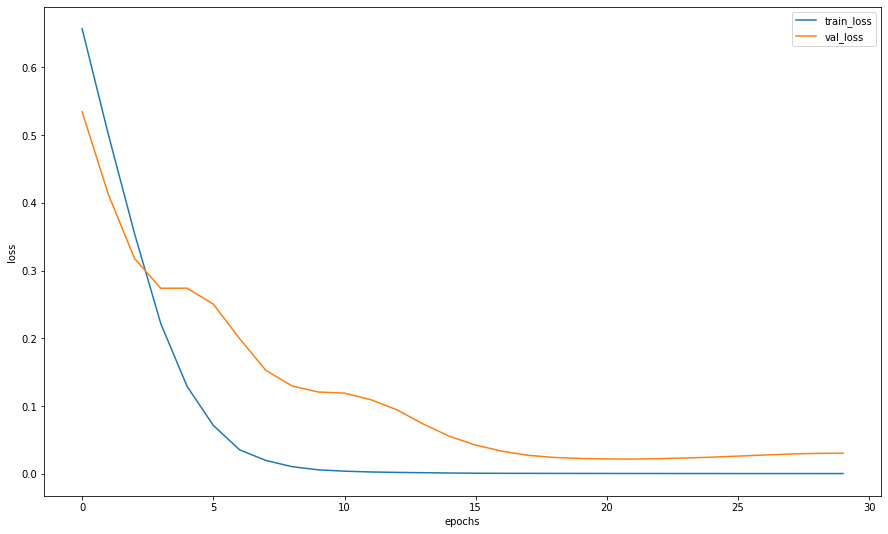

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
base_model = SimpleCnn(2).to(DEVICE)
base_model.load_state_dict(torch.load("gdrive/MyDrive/НТО/финал/bincl22.pth"))
base_model.eval()

SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1728, out_features=2, bias=True)
)

In [ ]:
idxs = list([i for i in range(len(val_dataset))])
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(base_model, imgs)

In [ ]:
label_encoder = pickle.load(open("nto.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
actual_labels=[label_encoder.classes_[i] for i in actual_labels]
print(actual_labels)
print(y_pred)
print(preds_class)

['eng', 'eng', 'eng', 'ru', 'ru', 'eng', 'eng', 'ru', 'eng', 'eng', 'eng', 'eng', 'eng', 'ru', 'ru', 'ru', 'eng', 'eng', 'eng', 'eng', 'eng', 'eng', 'ru', 'eng', 'eng', 'eng', 'eng', 'ru', 'ru', 'ru', 'ru', 'ru', 'ru', 'ru']
[0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1]
['eng', 'eng', 'eng', 'ru', 'ru', 'eng', 'eng', 'ru', 'eng', 'eng', 'eng', 'eng', 'eng', 'ru', 'ru', 'ru', 'eng', 'eng', 'eng', 'eng', 'eng', 'eng', 'ru', 'eng', 'eng', 'eng', 'eng', 'ru', 'ru', 'ru', 'ru', 'ru', 'ru', 'ru']


In [ ]:
def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.crop((470, 0, 1449, 979))
        image = image.resize(RESCALE_SIZE)
        return np.array(image)

In [ ]:
import cv2
image = DataLoader(LangDataset([cv2.imread('/content/data/train_segmentation/images/0_2_eng.jpg')], 'test', label_encoder, False))
label_encoder.classes_[np.argmax(predict(base_model, image))]

'eng'

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average=None)


array([1., 1.])